In [1]:
pip install --quiet wandb imageio gymnasium pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gymnasium[classic-control]

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import tensorflow as tf

import os
import wandb
import numpy as np
from time import time
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import gymnasium as gym
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
import pandas as pd

env = gym.make('Pendulum-v1', g=9.81, render_mode = "rgb_array")

In [4]:
class EpisodeSaver:
    def __init__(self, env, frames, algo, episode_number):
        self.env = env
        self.frames = frames
        self.dir = f'./gifs/{algo}/'
        self.episode_number = episode_number
        self.fname = f'episode_{self.episode_number}.gif'

        if not os.path.exists('./gifs'):
            os.mkdir('./gifs')

        if not os.path.exists(self.dir):
            os.mkdir(self.dir)

    def label_frames(self):
        labeled_frames = []

        for frame in self.frames:
            img = Image.fromarray(frame)
            draw = ImageDraw.Draw(img)
            # draw on each frame
            draw.text((10, 10), f'Episode: {self.episode_number}', fill=(255, 255, 255))
            labeled_frames.append(np.array(img))

        return labeled_frames

    def save(self):
        labeled_frames = self.label_frames()
        imageio.mimsave(self.dir + self.fname, labeled_frames, fps=60)

In [5]:
class ReplayBuffer:
    def __init__(self, max_size, state_size, action_size):
        self.memory_counter = 0
        self.max_length = max_size
        self.state_memory = np.zeros((self.max_length, state_size))
        self.new_state_memory = np.zeros((self.max_length, state_size))
        self.action_memory = np.zeros((self.max_length, action_size), dtype=np.int8)
        self.reward_memory = np.zeros(self.max_length)
        self.done_memory = np.zeros(self.max_length, dtype=np.float32)

    def append(self, state, action, reward, new_state, done):
        idx = self.memory_counter % self.max_length

        self.state_memory[idx] = state
        self.action_memory[idx] = action
        self.reward_memory[idx] = reward
        self.new_state_memory[idx] = new_state
        self.done_memory[idx] = 1 - done  # Flip the done flag for compatibility

        self.memory_counter += 1

    def sample(self, batch_size):
        max_mem = min(self.memory_counter, self.max_length)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        dones = self.done_memory[batch]

        return states, actions, rewards, new_states, dones

In [6]:
class Buffer(ReplayBuffer):
    def __init__(self, max_size, input_shape, n_actions):
        super(Buffer, self).__init__(max_size, input_shape, n_actions)

    def append(self, state, action, reward, state_, done):
        index = self.memory_counter % self.max_length
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.done_memory[index] = done

        self.memory_counter += 1

In [7]:
class DuelingDQN(Model):
    def __init__(self, n_actions):
        super(DuelingDQN, self).__init__()
        self.dense1 = Dense(128, activation='LeakyReLU')
        self.dense2 = Dense(128, activation='LeakyReLU')
        self.V = Dense(1, activation='linear')
        self.A = Dense(n_actions, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)

        Q = (V + (A - tf.math.reduce_mean(A, axis=1, keepdims=True)))

        return Q

    def advantage(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        A = self.A(x)

        return A

In [8]:
from tensorflow.keras.layers import LeakyReLU

class DuelingDQN(Model):
    def __init__(self, n_actions):
        super(DuelingDQN, self).__init__()
        self.dense1 = Dense(128, activation=LeakyReLU(alpha=0.01))
        self.dense2 = Dense(128, activation=LeakyReLU(alpha=0.01))
        self.V = Dense(1, activation='linear')
        self.A = Dense(n_actions, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)

        Q = (V + (A - tf.math.reduce_mean(A, axis=1, keepdims=True)))

        return Q

    def advantage(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        A = self.A(x)

        return A

In [9]:
class DuelingDQL:
    def __init__(self, env, alpha, gamma, epsilon, batch_size=64,
                epsilon_decay=1e-3, epsilon_min=0.01, replace=100, fname='Dueling_DQN'):
        self.env = env
        self.state_size = self.env.observation_space.shape[0]

        self.action_size = 9
        self.action_space = [n for n in range(self.action_size)]
        self.discrete_actions = np.linspace(-2.0, 2.0, num=self.action_size)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.replace = replace
        self.batch_size = batch_size
        self.fname = fname

        self.update_counter = 0
        self.memory = ReplayBuffer(10_000, self.state_size, self.action_size)
        self.q_eval = DuelingDQN(self.action_size)
        self.q_next = DuelingDQN(self.action_size)

        self.q_eval.compile(optimizer=Adam(learning_rate=alpha), loss='mse')

    def remember(self, state, action, reward, new_state, done):
        self.memory.append(state, action, reward, new_state, done)

    def act(self, observation):
        state = np.array([observation])
        rand = np.random.random()

        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.advantage(state)
            action = np.argmax(actions)

        return action

    def update(self):
        if self.memory.memory_counter < self.batch_size:
            return

        states, actions, rewards, states_, dones = self.memory.sample(self.batch_size)

        q_pred = self.q_eval(states)
        q_next = tf.math.reduce_max(self.q_next(states_), axis=1, keepdims=True).numpy()
        q_target = np.copy(q_pred)

        for idx, terminal in enumerate(dones):
            if terminal:
                q_next[idx] = 0.0
            action_idx = actions[idx]
            q_target[idx, action_idx] = rewards[idx] + self.gamma * q_next[idx]

        self.q_eval.train_on_batch(states, q_target)

        # self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        self.update_counter += 1

        if self.update_counter % self.replace == 0:
            self.update_target()

    def update_target(self):
        self.q_next.set_weights(self.q_eval.get_weights())

    def train(self, n_episodes, max_steps, log_wandb=False, update=True, save_episodes=False, save_interval=100):
        history = {'reward': [], 'avg_reward_100': [], 'steps': []}

        for episode in range(n_episodes):
            start_time = time()
            state = self.env.reset()
            state = state[0]
            done = False
            episode_reward = 0
            episode_steps = 0
            frames = []

            for _ in range(max_steps):
                action = self.act(state)
                new_state, reward, done, _, _ = self.env.step([self.discrete_actions[action]])
                frames.append(self.env.render())

                if update:
                    self.remember(state, action, reward, new_state, done)
                    self.update()

                state = new_state
                episode_reward += reward
                episode_steps += 1

                if done:
                    break

            if log_wandb:
                wandb.log({
                    'reward': episode_reward,
                    'steps': episode_steps,
                    'epsilon': self.epsilon
                })

            if save_episodes:
                if (episode + 1) % save_interval == 0 or (episode == 0):
                    s = EpisodeSaver(self.env, frames, self.fname, episode + 1)
                    s.save()

            history['reward'].append(episode_reward)
            history['avg_reward_100'].append(np.mean(history['reward'][-100:]))
            history['steps'].append(episode_steps)
            df = pd.DataFrame(history)
            df.to_csv(f'./assets/{self.fname}.csv', index=False)

            print(f'[EP {episode + 1}/{n_episodes}] - Reward: {episode_reward:.4f} - Steps: {episode_steps} - Eps: {self.epsilon:.4f} - Time: {time() - start_time:.2f}s')
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        self.env.close()

        if log_wandb:
            wandb.finish()

        self.save_model(self.fname)

        return history

    def save_model(self, fname):
        if not os.path.exists('./assets'):
            os.mkdir('./assets')

        self.q_eval.save(f'assets/{fname}', save_format='tf')

    def load_model(self, fname):
        self.q_eval = load_model(fname)

In [10]:
dueling_dql_agent = DuelingDQL(env=env, alpha=0.001, gamma=0.99, epsilon=1.0,batch_size=64, epsilon_decay=0.98,
                               epsilon_min=0.01, replace=10, fname='dueling_dql')

# Train the agent for 100 episodes with a maximum of 1000 steps per episode
history = dueling_dql_agent.train(n_episodes = 200, max_steps = 200, log_wandb = False,update = True, save_episodes = True, save_interval = 20)

[EP 1/200] - Reward: -876.3513 - Steps: 200 - Eps: 1.0000 - Time: 6.29s
[EP 2/200] - Reward: -1460.8041 - Steps: 200 - Eps: 0.9800 - Time: 3.54s
[EP 3/200] - Reward: -996.4324 - Steps: 200 - Eps: 0.9604 - Time: 3.70s
[EP 4/200] - Reward: -1259.3968 - Steps: 200 - Eps: 0.9412 - Time: 3.92s
[EP 5/200] - Reward: -1481.5522 - Steps: 200 - Eps: 0.9224 - Time: 3.86s
[EP 6/200] - Reward: -1071.6404 - Steps: 200 - Eps: 0.9039 - Time: 3.71s
[EP 7/200] - Reward: -1570.2493 - Steps: 200 - Eps: 0.8858 - Time: 3.75s
[EP 8/200] - Reward: -774.1318 - Steps: 200 - Eps: 0.8681 - Time: 3.80s
[EP 9/200] - Reward: -907.2886 - Steps: 200 - Eps: 0.8508 - Time: 3.84s
[EP 10/200] - Reward: -998.5811 - Steps: 200 - Eps: 0.8337 - Time: 3.86s
[EP 11/200] - Reward: -880.8851 - Steps: 200 - Eps: 0.8171 - Time: 3.79s
[EP 12/200] - Reward: -1128.3420 - Steps: 200 - Eps: 0.8007 - Time: 3.80s
[EP 13/200] - Reward: -1713.0134 - Steps: 200 - Eps: 0.7847 - Time: 3.59s
[EP 14/200] - Reward: -878.1400 - Steps: 200 - Eps: 0

INFO:tensorflow:Assets written to: assets/dueling_dql\assets


INFO:tensorflow:Assets written to: assets/dueling_dql\assets


In [11]:
import matplotlib.pyplot as plt

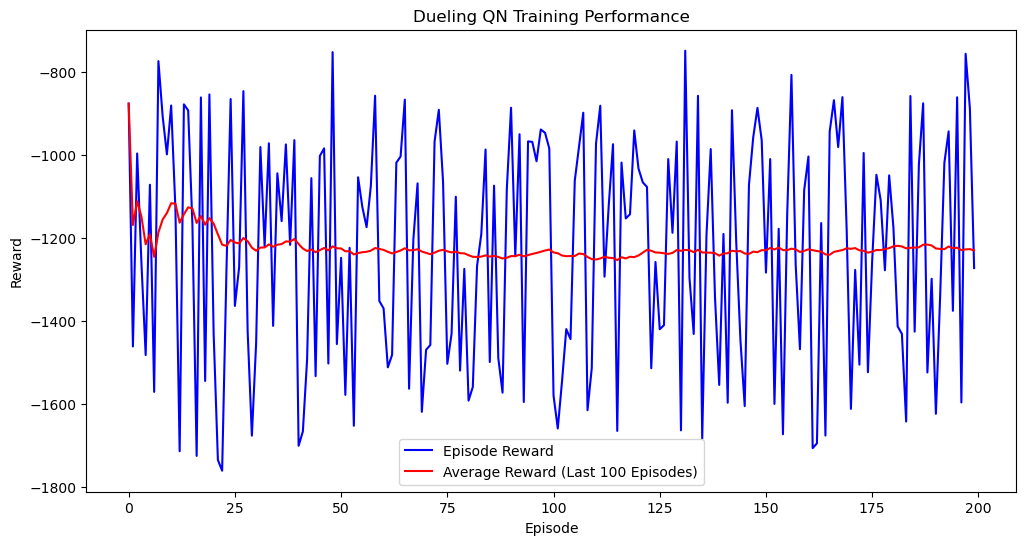

In [12]:
df = pd.read_csv('./assets/dueling_dql.csv')

plt.figure(figsize=(12, 6))
plt.plot(df['reward'], label='Episode Reward', color='blue')
plt.plot(df['avg_reward_100'], label='Average Reward (Last 100 Episodes)', color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Dueling QN Training Performance')
plt.legend()
plt.show()